In [1]:
import numpy as np
import pandas as pd
wig = pd.read_csv('wig.csv', usecols = ['Data', 'Zamkniecie', 'Wolumen'])
wig['Data'] = pd.to_datetime(wig['Data'])
wig.head()

,Data,Zamkniecie,Wolumen
0,1991-04-16,1000.0,325.0
1,1991-04-23,967.7,5905.0
2,1991-04-30,945.6,7162.0
3,1991-05-14,939.6,18300.0
4,1991-05-21,966.1,14750.0


In [2]:
wig.set_index('Data', inplace=True)

In [3]:
from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=True)
days = (wig.index - wig.index[0]).days[:, np.newaxis]
prices = wig['Zamkniecie'].values[:, np.newaxis]
model.fit(days, prices)
reg_prices = model.predict(days)
reg_prices = pd.DataFrame(reg_prices, index=wig.index)

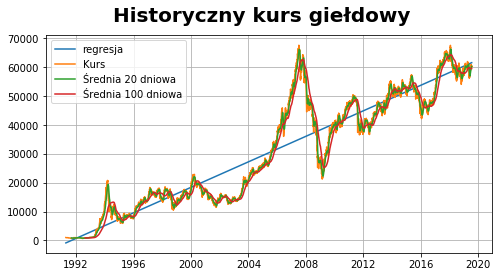

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=[8,4])
plt.grid(True)
plt.suptitle('Historyczny kurs giełdowy', fontsize=20, fontweight='bold')
plt.plot(reg_prices, label='regresja')
plt.plot(wig['Zamkniecie'], label='Kurs')
ma_20 = wig['Zamkniecie'].rolling(20).mean()
plt.plot(ma_20, label='Średnia 20 dniowa')
ma_100 = wig['Zamkniecie'].rolling(100).mean()
plt.plot(ma_100, label='Średnia 100 dniowa')
plt.legend(loc=2)

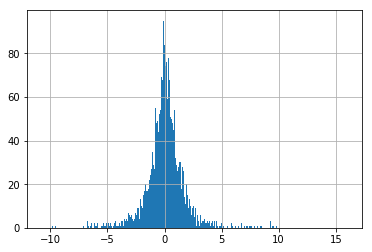

In [5]:
wig['zmiana'] = (wig['Zamkniecie'] / wig['Zamkniecie'].shift() - 1) * 100
wig['zmiana'].hist(bins=1000)

0.24285893221678947

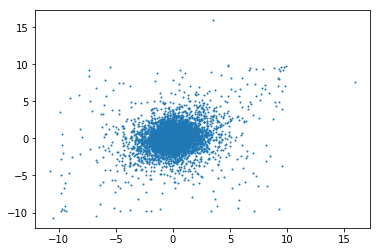

In [6]:
plt.scatter(wig['zmiana'], wig['zmiana'].shift(), s=1)
wig['zmiana'].autocorr()

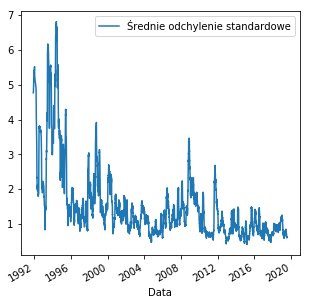

In [7]:
volitality = wig['zmiana'].rolling(30).std()
plt.figure(figsize=[5,5])
volitality.plot(label='Średnie odchylenie standardowe')
plt.legend()

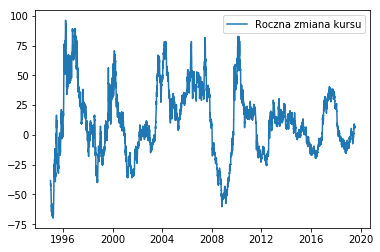

In [8]:
full_dates = pd.date_range(start='16/4/1991', end='18/7/2019')
temp = wig.reindex(full_dates)
temp = temp.fillna(method='ffill')
temp.dropna(inplace=True)
temp['r_zmiana'] = (temp['Zamkniecie'] / temp['Zamkniecie'].shift(365) - 1) * 100
wig = temp.reindex(wig.index)
wig.dropna(inplace=True)
wig = wig.loc['1995':]
plt.plot(wig['r_zmiana'], label='Roczna zmiana kursu')
plt.legend()

In [9]:
class Monte_Carlo:
    def __init__(self, data, num_days=365, num_simulations=10):
        self.data = data
        self.num_simulations = num_simulations
        self.num_days = num_days
        self.num_simulations = num_simulations
    
    def clean_data(self):
        self.last_price = self.data['Zamkniecie'][-1]
        self.returns = self.data['zmiana']
        self.std = (self.returns / 100).std()
        
    def date_index(self):
        first_date = self.data.index[-1] + pd.Timedelta(days=1)
        last_date = first_date + pd.Timedelta(days=self.num_days)
        index = pd.date_range(first_date, last_date, freq='B')
        return index
        
    def sim_monte_carlo(self):
        simulations = []
        num_simulations = self.num_simulations
        date_index = self.date_index()
        for i in range(num_simulations):
            prices = []
            current_price = self.last_price
            for j in range(date_index.shape[0]):
                forecast_price = current_price * (1 + np.random.normal(0, self.std))
                prices.append(forecast_price)
                current_price = forecast_price
            simulations.append(prices)
        df = pd.DataFrame(simulations).T
        self.simulations = df.set_index(date_index)
        
    def get_or_make_sim(self):
        if not hasattr(self, 'simulations'):
            self.sim_monte_carlo()
        return self.simulations

    def plot_data(self):
        simulations = self.get_or_make_sim()
        num_days = self.num_days
        last_price = self.last_price
        fig = plt.figure()
        plt.plot(simulations)
        plt.axhline(y=last_price, color='r', linestyle='-')
        title = 'Symulacja Monte Carlo'
        fig.suptitle(title)
        plt.ylabel('Prognozowane Ceny')
        plt.xlabel('Daty')
        plt.show()

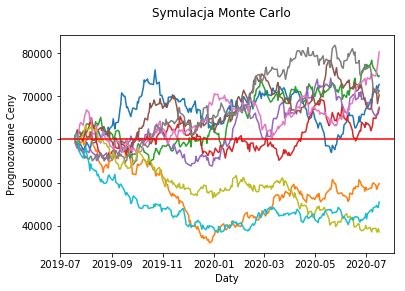

In [10]:
results = Monte_Carlo(wig)
results.clean_data()
results.plot_data()

In [11]:
wig.head()

,Zamkniecie,Wolumen,zmiana,r_zmiana
Data,,,,
1995-01-02,7674.4,2623478.0,2.693661,-38.303722
1995-01-03,7964.9,3763225.0,3.785312,-38.941954
1995-01-04,7814.2,3287448.0,-1.892051,-41.446930
1995-01-05,7881.9,3090882.0,0.866371,-40.939643
1995-01-06,7538.9,1979411.0,-4.351743,-43.029547


In [12]:
class BaseIndicator:
    
    def __init__(self, data):
        self.data = data
    
    def test(self, start=None, end=None, **kwargs):
        data = self.add_signal(**kwargs)
        data = data.loc[start:end]
        hold = False
        results = [1, ]
        for i in range(data.shape[0]):
            last_result = results[-1]
            signal = data.iloc[i]['signal']
            if signal == 'B':
                hold = True
            elif signal == 'S':
                hold = False
            if hold == True:
                last_result *= 1 + data.iloc[i]['zmiana']/100
            results.append(last_result)
        df = pd.DataFrame(results[1:], columns=['results',])
        df.set_index(data.index, inplace=True)
        return pd.concat([data, df], axis=1)


class RSI(BaseIndicator):

    def get_rsi(self, n=14):
        delta = self.data['Zamkniecie'].diff()
        up, down = delta.copy(), delta.copy()
        up[up < 0] = 0
        down[down > 0] = 0
        roll_up = up.rolling(n).mean()
        roll_down = down.rolling(n).mean().abs()
        roll_up[-1], roll_down[-1]
        rs = roll_up / roll_down
        rsi = 100 - 100/(1 + rs)
        return rsi
    
    def add_signal(self, n=14, buy_val=30, sell_val=70):
        data = self.data
        data['RSI'] = self.get_rsi(n)
        data['signal'] = 'N'
        data.loc[
            (data['RSI'] > buy_val) & (data['RSI'].shift(1) < buy_val),
            'signal'] = 'B'
        data.loc[
            (data['RSI'] < sell_val) & (data['RSI'].shift(1) > sell_val), 
            'signal'] = 'S'
        return data

class BollingerBands(BaseIndicator):     
    def get_bands(self):
        data = self.data.copy()
        data['upper_band'] = data['MA_20'] + 2 * data['Zamkniecie'].rolling(20).std()
        data['lower_band'] = data['MA_20'] - 2 * data['Zamkniecie'].rolling(20).std()
        return data
    
    def add_signal(self):
        data = self.get_bands()
        data['bollinger_signal'] = 'N'
        data.loc[
            (data['Zamkniecie'] >= data['upper_band'])
            & (data['Zamkniecie'].shift(1) < data['upper_band'].shift(1)), 
            'bollinger_signal'] = 'B'
        data.loc[
            (data['Zamkniecie'] <= data['lower_band'])
            & (data['Zamkniecie'].shift() > data['lower_band'].shift(1)),
            'bollinger_signal'] = 's'
        return data

    
class BaseAverage(BaseIndicator):
    def get_average(self, interval):
        data = self.data.copy()
        name = f'MA_{interval}'
        return data['Zamkniecie'].rolling(interval).mean()

    
class MACD(BaseAverage):
    def add_averages(self, short=12, long=26):
        data = self.data.copy()
        data['MA_short'] = self.get_average(short)
        data['MA_long'] = self.get_average(long)
        return data
    
    def add_signal(self, short=12, long=26):
        data = self.add_averages(short, long)
        data['signal'] = 'N'
        data.loc[
            (data['MA_short'] > data['MA_long'])
            & (data['MA_short'].shift() < data['MA_long'].shift()),
            'signal'] = 'B'
        data.loc[
            (data['MA_short'] < data['MA_long'])
            & (data['MA_short'].shift() > data['MA_long'].shift()),
            'signal'] = 'S'
        return data

    
class MovingAverage(BaseAverage):
    def __init__(self, data):
        self.data = data

    def add_signal(self, interval):
        data = self.data.copy()
        name = f'MA_{interval}'
        data[name] = self.get_average(interval)
        data[f'{name}_signal'] = data[name] < data['Zamkniecie']
        return data
        
    def test(self, start, end, interval):
        data = self.add_signal(interval)
        data = data.loc[start:end]
        name = f'MA_{interval}'
        data[f'MA_results'] = (
            1 + data[f'{name}_signal'].shift() * (data['zmiana']/interval)
        ).cumprod()
        return data

class Strategies:
    def __init__(self, data):
        self.data = data
        self.RSI = RSI(data)
        self.BOL= BollingerBands(data)
        self.MA = MovingAverage(data)
        self.MACD = MACD(data)
        
    def frequency_dates(self):
        first = self.data.index[0].date()
        last = self.data.index[-1].date()
        dates = pd.date_range(first, last, freq='3M')
        start_dates = dates[:-1]
        stop_dates = dates[1:]
        return start_dates, stop_dates
    
    def multi(self, name):
        class_ = getattr(self, name)
        start, stop = self.frequency_dates()
        all_tests = []
        for i in range(len(start)):
            result = class_.test(start=start[i], end=stop[i])
            all_tests.append(result[f'{name}_results'][-1] - 1)
        df = pd.DataFrame({
            'start': start, 
            'stop': stop,
            'results': all_tests
        })
        return df
    
    def prepare_data(self, name, start=None, end=None, interval=None, **kwargs):
        class_ = getattr(self, name)
        if start == None:
            start = self.data.index[1]
        if end == None:
            end = self.data.index[-1]
        
        if name == 'MACD':
            return class_.test(start, end, **kwargs)
        
        elif name == 'MA':
            if not interval:
                msg = """
                If MA needs interval. Interval is a number of trading days 
                from which moving avrage is taken
                """
                raise ValueError(msg)
            return class_.test(start, end, interval)
        return class_.test(start, end)
        
    def plot(self, name, start=None, end=None, interval=None, **kwargs):
        data = self.prepare_data(name, start, end, interval, **kwargs)
        benchmark = 100 * (1 + data['zmiana'] / 100).cumprod()
        strategy = 100 * data[f'results']
        fig = plt.figure()
        fig.suptitle(f'Wyniki strategii {name}')
        benchmark.plot(label=f'Wynik WIG')
        strategy.plot(label=f'Wynik: {name}')
        plt.legend()

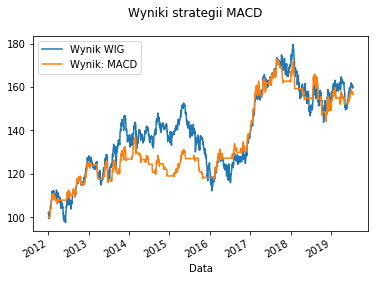

In [13]:
tester = Strategies(wig)
tester.plot(name='MACD', start='2012')